In [3]:
import matplotlib.pyplot as plt
import torch
from PIL import Image

In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import Dataset

# Define your data directory and transformations
data_dir = "./data"
transform = transforms.Compose(
    [
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
    ]
)
# Create DataLoader
dataset = Dataset(data_dir="./data", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [5]:
iter = iter(dataloader)

In [6]:
imagePath, labels, segPath = next(iter)

In [7]:
segPath[0]

'/home/charbel/Desktop/stages/inmind.ai/material/week4-computervision/mywork/data/rgb_0293.png'

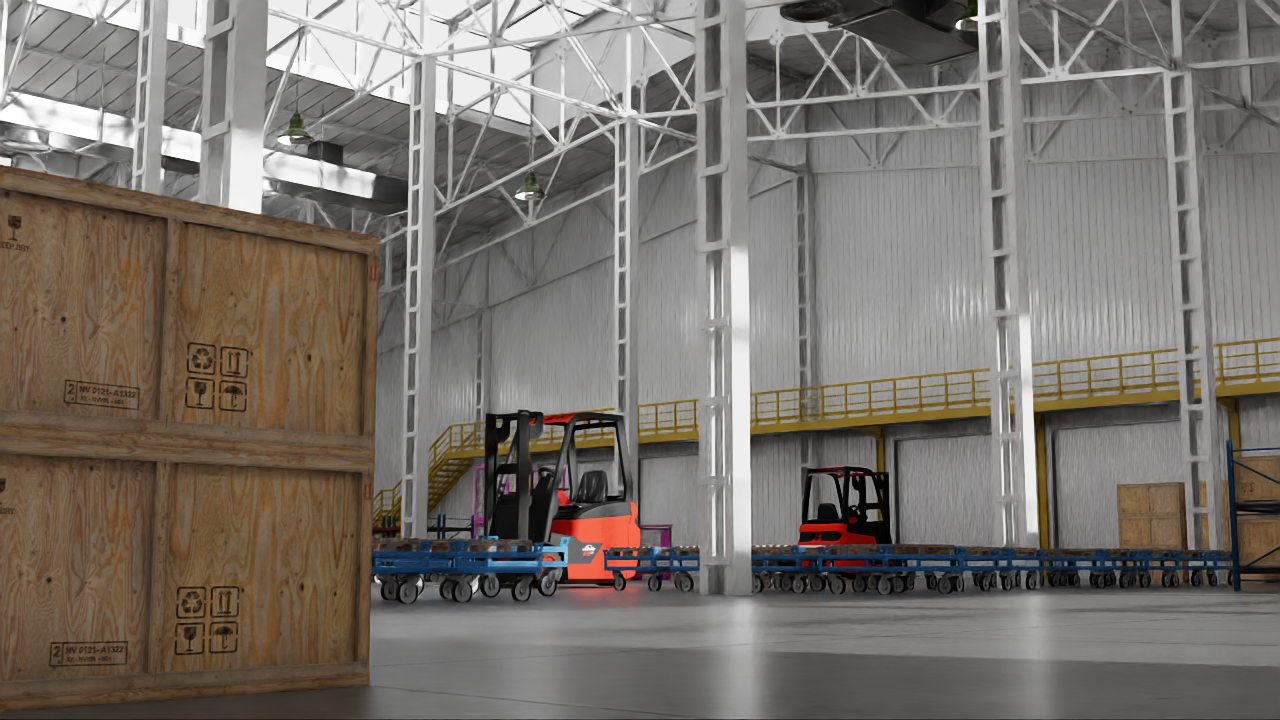

In [8]:
image = Image.open(imagePath[0])
image

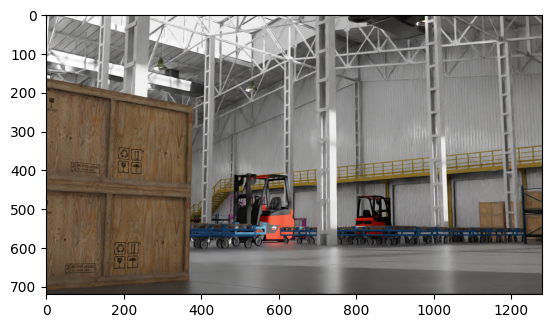

In [9]:
plt.imshow(Image.open(segPath[0]))

In [10]:
import onnxruntime as ort
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms

color_map = torch.tensor(
    [
        [0, 0, 0],
        [25, 82, 255],
        [255, 25, 197],
        [140, 255, 25],
        [0, 0, 0],
        [226, 255, 25],
        [255, 197, 25],
        [140, 25, 255],
        [54, 255, 25],
        [25, 255, 82],
        [255, 111, 25],
    ]
)


def map_one_hot_to_image(one_hot, color_map):
    batch_size, height, width, num_colors = one_hot.shape

    # Use argmax to find the index of the 1 in each one-hot vector
    indices = torch.argmax(one_hot, dim=-1)

    # Use the indices to select colors from the color map
    output = color_map[indices]

    return output


def perform_inference(image_path, model_path):
    # Load the ONNX model
    session = ort.InferenceSession(model_path)
    # Load and preprocess the image
    image = Image.open(image_path)
    image = torch.tensor(np.expand_dims(np.array(image), axis=0), dtype=torch.float32)[
        :, :, :, :3
    ]
    resize = transforms.Resize((640, 640))
    image = image.permute(0, 3, 2, 1)
    image = resize(image)
    image = image.permute(0, 3, 2, 1) / 255

    # Perform inference
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: np.array(image)})
    outputs = torch.tensor(outputs[0][0]).permute(1, 2, 0)
    outputs = torch.tensor(np.expand_dims(np.array(outputs), axis=0))
    outputs = map_one_hot_to_image(outputs, color_map)
    return outputs, image


# Example usage:
# image_path = "./data/rgb_0009.png"
model_path = "./bestModels/fcn.onnx"
output, image = perform_inference(imagePath[0], model_path)

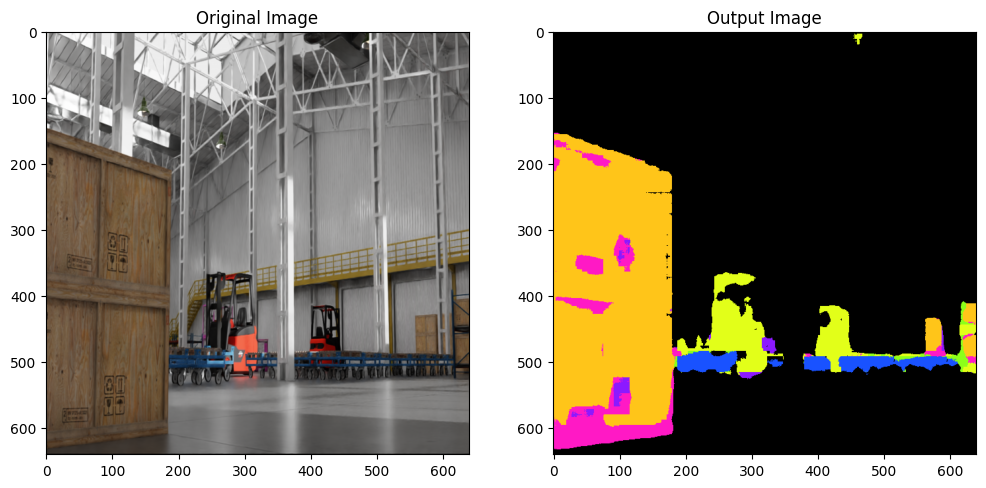

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image[0])
axs[0].set_title("Original Image")

axs[1].imshow(output[0])
axs[1].set_title("Output Image")

plt.show()

In [12]:
import sys

sys.path.append("./yoloInference")
from yoloInference.detect import detect_objects

In [45]:
output, time = detect_objects(
    "./bestModels/yolo.pt",
    imagePath[0],
    conf_thres=0.35,
    iou_thres=0.45,
    img_size=640,
)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


In [15]:
# from plots import displayImagesWithBoxesYolo

In [16]:
boxes = [x[1:5] for x in output]

In [63]:
def displayImagesWithBoxesYolo(image_path, bounding_boxes):
    """
    Plots bounding boxes on an image.

    Args:
      image_path: Path to the image file.
      bounding_boxes: List of bounding boxes in the format (x_center, y_center, width, height).
    """
    print("ete")

    # Load the image
    image = np.array(Image.open(image_path))[:, :, :3]
    image = np.array(torch.tensor(image).permute(1, 0, 2))
    plt.imshow(image)

    # Convert bounding boxes to xmin, ymin, xmax, ymax
    for x_center, y_center, width, height in bounding_boxes:

        xmin = int(x_center - width / 2) * image.shape[0]
        ymin = int(y_center - height / 2) * image.shape[1]
        xmax = int(x_center + width / 2) * image.shape[0]
        ymax = int(y_center + height / 2) * image.shape[1]

        # Plot the bounding box
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
        plt.gca().add_patch(rect)

    plt.axis("off")
    plt.show()
    plt.savefig("output_image.png")  # Replace with your desired filename and format

In [64]:
plt.imshow(Image.open(imagePath[0]))
plt.show()

/tmp/ipykernel_20227/585460830.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [65]:
boxes = [x[1:5] for x in labels]

In [66]:
displayImagesWithBoxesYolo(imagePath[0], boxes)

ete


/tmp/ipykernel_20227/2746330993.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


The output of the function below, i did not know how to process it , it needs non max suppression and confidence deletion but i did not understand the output 
Here i used onnx format to do inference

In [ ]:
def yoloInference(image_path, model_path):
    # Load the ONNX model
    session = ort.InferenceSession(model_path)
    print("modelread")
    image = Image.open(image_path)
    image_tensor = torch.tensor(
        np.expand_dims(np.array(image)[:, :, :3], axis=0), dtype=torch.float32
    )  # Add batch dimension
    image_tensor = image_tensor.permute(0, 3, 1, 2)

    resize = transforms.Resize((640, 640))  # Define resize transformation
    image_tensor = resize(image_tensor)

    # Perform inference
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: np.array(image_tensor)})
    return outputs

In [ ]:
output = yoloInference(image_path, "./bestModels/yolo.onnx")

Here i used torchscript.pt to run inferences but also i did not understand the output like before

In [ ]:
## Input
### Import libraries
from ultralytics import YOLO
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch

### Setup variables
onnx_model_path = "./bestModels/yolo.onnx"  # Path to your ONNX model
image_path = "./data/rgb_0006.png"
path = "./bestModels/best.torchscript.pt"

# Load the YOLO model from the ONNX file
# model = YOLO(onnx_model_path)
model = torch.jit.load("./bestModels/yolo.torchscript.pt")
model.task = "detect"
# Export to PyTorch format

# Now try using the exported PyTorch model
image = np.array(Image.open(image_path))[:, :, :3]
image_tensor = torch.tensor(
    np.expand_dims(np.array(image)[:, :, :3], axis=0), dtype=torch.float32
)  # Add batch dimension
image_tensor = image_tensor.permute(0, 3, 1, 2)
resize = transforms.Resize((640, 640))  # Define resize transformation
image_tensor = resize(image_tensor)
image_tensor = torch.tensor(image_tensor, dtype=torch.float32)
output = model(image_tensor)